In [318]:
import numpy as np
from matplotlib import pyplot as plt
import scipy

In [319]:
import numpy as np

def read_dca1000(file_name, num_adc_samples = 256, num_adc_bits = 16, num_rx = 4):
    """
    Reads the binary file produced by the DCA1000 and Mmwave Studio.
    
    Args:
        file_name (str): Path to the .bin file.
        
    Returns:
        np.ndarray: A numpy array of shape (numRX, numChirps * numADCSamples) containing complex data.
    """
    
    # --- Global Variables (Change based on sensor config) ---
    # num_adc_samples = 256    # number of ADC samples per chirp
    # num_adc_bits = 16        # number of ADC bits per sample
    # num_rx = 4               # number of receivers
    num_lanes = 2            # do not change. number of lanes is always 2
    is_real = False          # set to True if real only data, False if complex data

    # --- Read File ---
    # Read .bin file as int16
    try:
        adc_data = np.fromfile(file_name, dtype=np.int16)
    except FileNotFoundError:
        print(f"Error: File {file_name} not found.")
        return None

    # If 12 or 14 bits ADC per sample compensate for sign extension
    if num_adc_bits != 16:
        l_max = 2**(num_adc_bits-1) - 1
        adc_data[adc_data > l_max] -= 2**num_adc_bits

    file_size = adc_data.size

    # --- Process Data ---
    if is_real:
        # Real data reshape
        num_chirps = file_size // (num_adc_samples * num_rx)
        
        # Reshape to match MATLAB's column-major (F) logic
        lvds = adc_data.reshape(num_adc_samples * num_rx, num_chirps, order='F')
        lvds = lvds.T 
    else:
        # Complex data
        # File size is halved because 2 integers make 1 complex number
        num_chirps = file_size // (2 * num_adc_samples * num_rx)
        
        # The DCA1000 usually interleaves data in a specific pattern for 2 lanes:
        # [Real1, Real2, Imag1, Imag2, Real3, Real4, Imag3, Imag4...]
        # We reshape to (-1, 4) to separate these chunks
        adc_data = adc_data.reshape(-1, 4)
        
        # Construct complex data
        # Real parts are columns 0 and 1; Imaginary parts are columns 2 and 3
        data_real = adc_data[:, [0, 1]].flatten()
        data_imag = adc_data[:, [2, 3]].flatten()
        complex_data = data_real + 1j * data_imag
        
        # Reshape to dimensions: (SamplesPerChirp * NumRX) x NumChirps
        # We use order='F' to mimic MATLAB's default column-filling behavior
        lvds = complex_data.reshape(num_adc_samples * num_rx, num_chirps, order='F')
        
        # Transpose to get (NumChirps) x (SamplesPerChirp * NumRX)
        lvds = lvds.T

    # --- Organize Data per RX ---
    # Currently, lvds shape is (num_chirps, num_rx * num_adc_samples)
    # The columns are packed as: [RX1_Samples | RX2_Samples | RX3_Samples | RX4_Samples]
    
    # 1. Reshape to separate RX channels: (NumChirps, NumRX, NumSamples)
    lvds = lvds.reshape(num_chirps, num_rx, num_adc_samples)
    
    # 2. Transpose to bring RX to the front: (NumRX, NumChirps, NumSamples)
    lvds = lvds.transpose(1, 0, 2)
    
    # 3. Flatten the last two dimensions to get continuous samples per RX
    # Final Shape: (NumRX, NumChirps * NumSamples)
    ret_val = lvds.reshape(num_rx, -1)

    return ret_val

# Example Usage:
# radar_data = read_dca1000('adc_data.bin')
# print(radar_data.shape)

In [320]:
# fileName="Sitting1Tx1Rx/static_sitting2.bin"
# fileName="Sitting1Tx1Rx/static_sitting2_Raw_0.bin"
# fileName="Sitting1Tx1Rx/static_sitting_no_breathing3.bin"
# fileName="Sitting1Tx1Rx/nothing.bin"
fileName="Sitting1Tx1Rx/static_sitting_heavy_breathing2.bin"
dca_out=read_dca1000(fileName, num_rx=1)

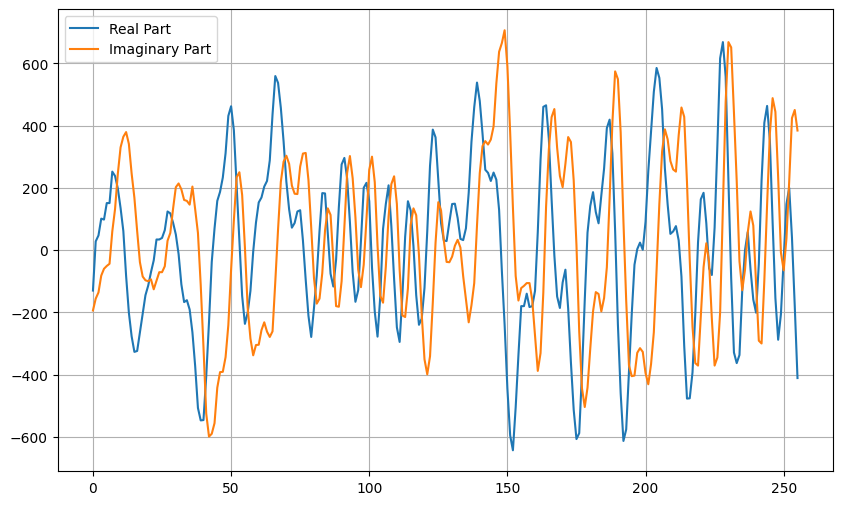

In [321]:
# Time domain
plt.figure(figsize=(10, 6))
chirp=0
data=dca_out[0][chirp*256:(chirp+1)*256]
real=data.real
complex_data=data.imag
plt.plot(real,label='Real Part')
plt.plot(complex_data,label='Imaginary Part')
plt.grid()
plt.legend()

In [322]:
print(dca_out)
print(dca_out.shape)

[[-130.-194.j   28.-156.j   47.-136.j ...  -28.+495.j -232.+560.j
  -433.+441.j]]
(1, 4194304)


In [323]:
sampling_frequency = 10000 * 1e3 # Hz (example)
S=29.982 * 1e12 #mhz/us
start_freq=77*1e9
ramp_end=60 #us
idle_time=100 #us
periodicity=40 #us
chirp_cycle_time=(idle_time + ramp_end + periodicity) * 1e-6
pulse_repetation_interval = 1/chirp_cycle_time
num_rx=1
num_chirps=1
samples_per_chirp=256
chirps_per_frame=128
range_max=3e8*sampling_frequency/ (2*S)

frames_per_loop=128
chirp_loops=128

dca_out.shape[1]/samples_per_chirp/chirp_loops/frames_per_loop

1.0

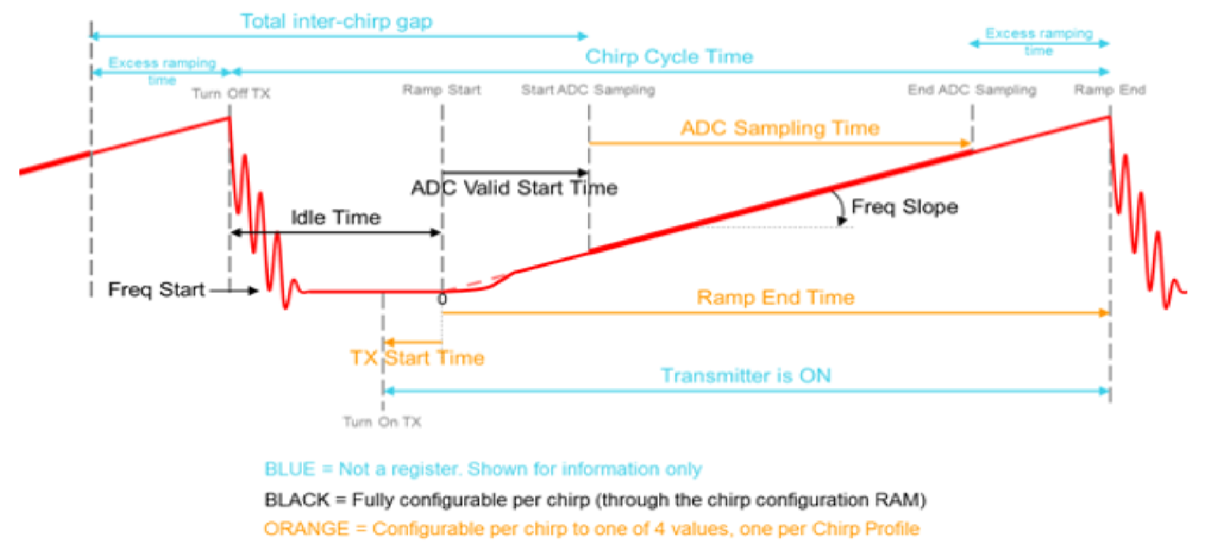

In [324]:
dca_out[0][0]

np.complex128(-130-194j)

In [325]:
window = np.hanning(256)
print(window.shape)
print(window[np.newaxis, :].shape)

(256,)
(1, 256)


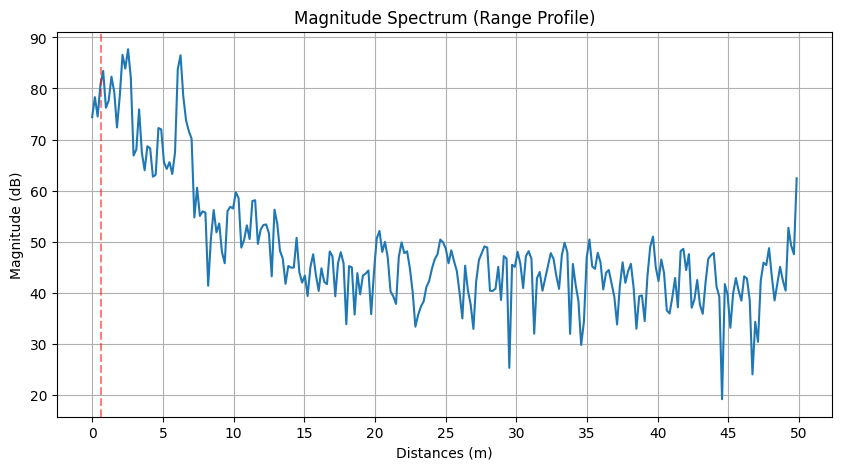

In [326]:
def magnitude_dbfs(fft_data, adc_bits=16):
        """
        Convert complex FFT to magnitude in dBFS (decibels relative to full scale)
        
        Args:
            fft_data: Complex FFT output array
            adc_bits: ADC resolution in bits (default 12-bit for typical radar)
        
        Returns:
            magnitude_dbfs: Magnitude in dBFS scale
        """
        # Calculate full scale value based on ADC bits
        full_scale = 2**(adc_bits - 1)  # For signed ADC
        
        # Get magnitude of FFT
        magnitude = np.abs(fft_data)
        
        # Normalize by FFT length (important for proper scaling)
        magnitude_normalized = magnitude / len(fft_data)
        
        # Convert to dBFS: 20*log10(magnitude / full_scale)
        # Add small epsilon to avoid log(0)
        magnitude_dbfs = 20 * np.log10(magnitude_normalized / full_scale + 1e-10)
        
        return magnitude_dbfs

def magnitude_db(fft_data):
        """Convert complex FFT to magnitude in dB"""
        magnitude = np.abs(fft_data)
        magnitude_db = 20 * np.log10(magnitude + 1e-10)  # Add small value to avoid log(0)
        return magnitude_db

def rangeFFT(signal, plot=False):
    global range_max
    num_samples = len(signal)
    window = np.hanning(num_samples)
    signal_windowed = signal * window
    y=np.fft.fft(signal_windowed)
    fft_magnitude = magnitude_db(y,)
    # fft_magnitude = magnitude_dbfs(y,adc_bits=16)

    # frequencies = np.fft.fftshift(np.fft.fftfreq(num_samples, d=1/(sampling_frequency)))
    # distances=np.abs(frequencies)*3e8/2/S
    distances=np.arange(num_samples) * range_max / num_samples
    # print([distances[0],distances[-100]])
    if plot:
        # Plot the magnitude spectrum
        plt.figure(figsize=(10, 5))
        # plt.plot(frequencies[:num_samples//2], fft_magnitude[:num_samples//2]) # Plot only positive frequencies
        # plt.plot(distances[:num_samples//2], fft_magnitude[:num_samples//2]) # Plot only positive frequencies
        plt.plot(distances, fft_magnitude) # Plot only positive frequencies
        plt.title('Magnitude Spectrum (Range Profile)')
        # plt.xlabel('Frequency (Hz) / Range Bins')
        plt.xlabel('Distances (m)')
        plt.ylabel('Magnitude (dB)')
        plt.xticks(np.arange(0,range_max,5))
        plt.grid(True)
        plt.axvline(x=0.6, color='r', linestyle='--', alpha=0.5)
        plt.show()
    return y, fft_magnitude, distances

magAt58cm=[]
sigAt58cm=[]
distances_all=[]
rangeFFTAcrossChirps=np.zeros([samples_per_chirp,len(dca_out[0])//samples_per_chirp],dtype=np.complex128)
for chirp_no in range(len(dca_out[0])//samples_per_chirp):
    if chirp_no==0:
        fft_signal, fft_magnitude, distances=rangeFFT(dca_out[0][chirp_no*256:(chirp_no+1)*256], plot=True)
    else:
        fft_signal, fft_magnitude, distances=rangeFFT(dca_out[0][chirp_no*256:(chirp_no+1)*256], plot=False)
    rangeFFTAcrossChirps[:,chirp_no]=fft_signal
    sigAt58cm.append(fft_signal[3]) 
    magAt58cm.append(fft_magnitude[3]) 
    distances_all.append(distances[3])
sigAt58cm=np.array(sigAt58cm)
magAt58cm=np.array(magAt58cm)

In [327]:
distances

array([ 0.        ,  0.19542976,  0.39085952,  0.58628927,  0.78171903,
        0.97714879,  1.17257855,  1.3680083 ,  1.56343806,  1.75886782,
        1.95429758,  2.14972734,  2.34515709,  2.54058685,  2.73601661,
        2.93144637,  3.12687613,  3.32230588,  3.51773564,  3.7131654 ,
        3.90859516,  4.10402491,  4.29945467,  4.49488443,  4.69031419,
        4.88574395,  5.0811737 ,  5.27660346,  5.47203322,  5.66746298,
        5.86289274,  6.05832249,  6.25375225,  6.44918201,  6.64461177,
        6.84004152,  7.03547128,  7.23090104,  7.4263308 ,  7.62176056,
        7.81719031,  8.01262007,  8.20804983,  8.40347959,  8.59890935,
        8.7943391 ,  8.98976886,  9.18519862,  9.38062838,  9.57605813,
        9.77148789,  9.96691765, 10.16234741, 10.35777717, 10.55320692,
       10.74863668, 10.94406644, 11.1394962 , 11.33492596, 11.53035571,
       11.72578547, 11.92121523, 12.11664499, 12.31207474, 12.5075045 ,
       12.70293426, 12.89836402, 13.09379378, 13.28922353, 13.48

Text(0, 0.5, 'Magnitude at 0.58m (dB)')

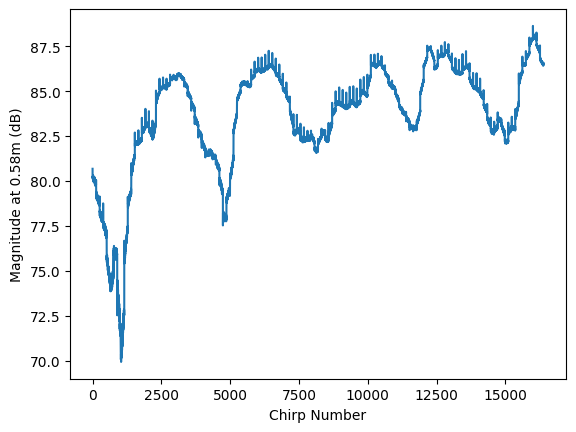

In [328]:
plt.plot(np.arange(rangeFFTAcrossChirps.shape[1]),magnitude_db(rangeFFTAcrossChirps[3,:]))
# plt.plot(np.arange(len(magAt58cm)),magAt58cm)
plt.xlabel('Chirp Number')
plt.ylabel('Magnitude at 0.58m (dB)')

Text(0, 0.5, 'magnitude (dB)')

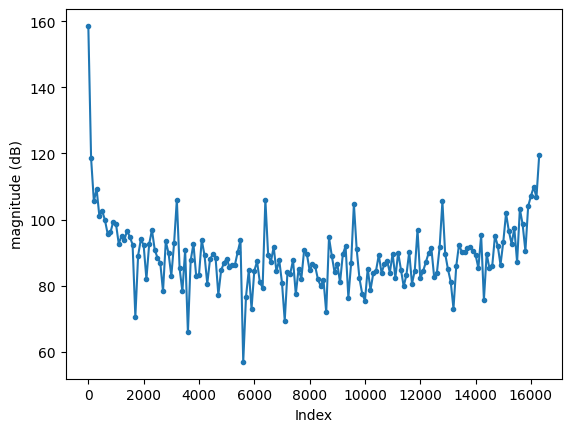

In [329]:
# def dopFFT(signal, plot=False):
#     global range_max
#     num_samples = len(signal)
#     window = np.hanning(num_samples)
#     signal_windowed = signal * window
#     y=np.fft.fft(signal_windowed)
#     fft_magnitude = magnitude_db(y,)
#     # fft_magnitude = magnitude_dbfs(y,adc_bits=16)

#     # frequencies = np.fft.fftshift(np.fft.fftfreq(num_samples, d=1/(sampling_frequency)))
#     # distances=np.abs(frequencies)*3e8/2/S
#     distances=np.arange(num_samples) * range_max / num_samples
#     # print([distances[0],distances[-100]])
#     if plot:
#         # Plot the magnitude spectrum
#         plt.figure(figsize=(10, 5))
#         # plt.plot(frequencies[:num_samples//2], fft_magnitude[:num_samples//2]) # Plot only positive frequencies
#         # plt.plot(distances[:num_samples//2], fft_magnitude[:num_samples//2]) # Plot only positive frequencies
#         plt.plot(distances, fft_magnitude) # Plot only positive frequencies
#         plt.title('Magnitude Spectrum (Range Profile)')
#         # plt.xlabel('Frequency (Hz) / Range Bins')
#         plt.xlabel('Distances (m)')
#         plt.ylabel('Magnitude [dBFS]')
#         plt.xticks(np.arange(0,range_max,5))
#         plt.grid(True)
#         plt.axvline(x=0.6, color='r', linestyle='--', alpha=0.5)
#         plt.show()
#     return y, fft_magnitude, distances
window = np.hanning(num_chirps)
dop_all_fft=np.fft.fft(rangeFFTAcrossChirps * window,axis=1)
dop_fft=dop_all_fft[3,:]
skip=100
plt.plot(np.arange(len(dop_fft)/skip)*skip,magnitude_db(dop_fft)[::skip],'.-')
# plt.plot(np.arange(len(dop_fft)/skip)*skip,dop_fft[::skip],'.-')
plt.xlabel("Index")
plt.ylabel("magnitude (dB)")

Number of samples: 2048
Number of chirps: 8
Mean phase acceleration: 39538025377.21 rad/s²
Estimated target acceleration: 24516904.59 m/s²


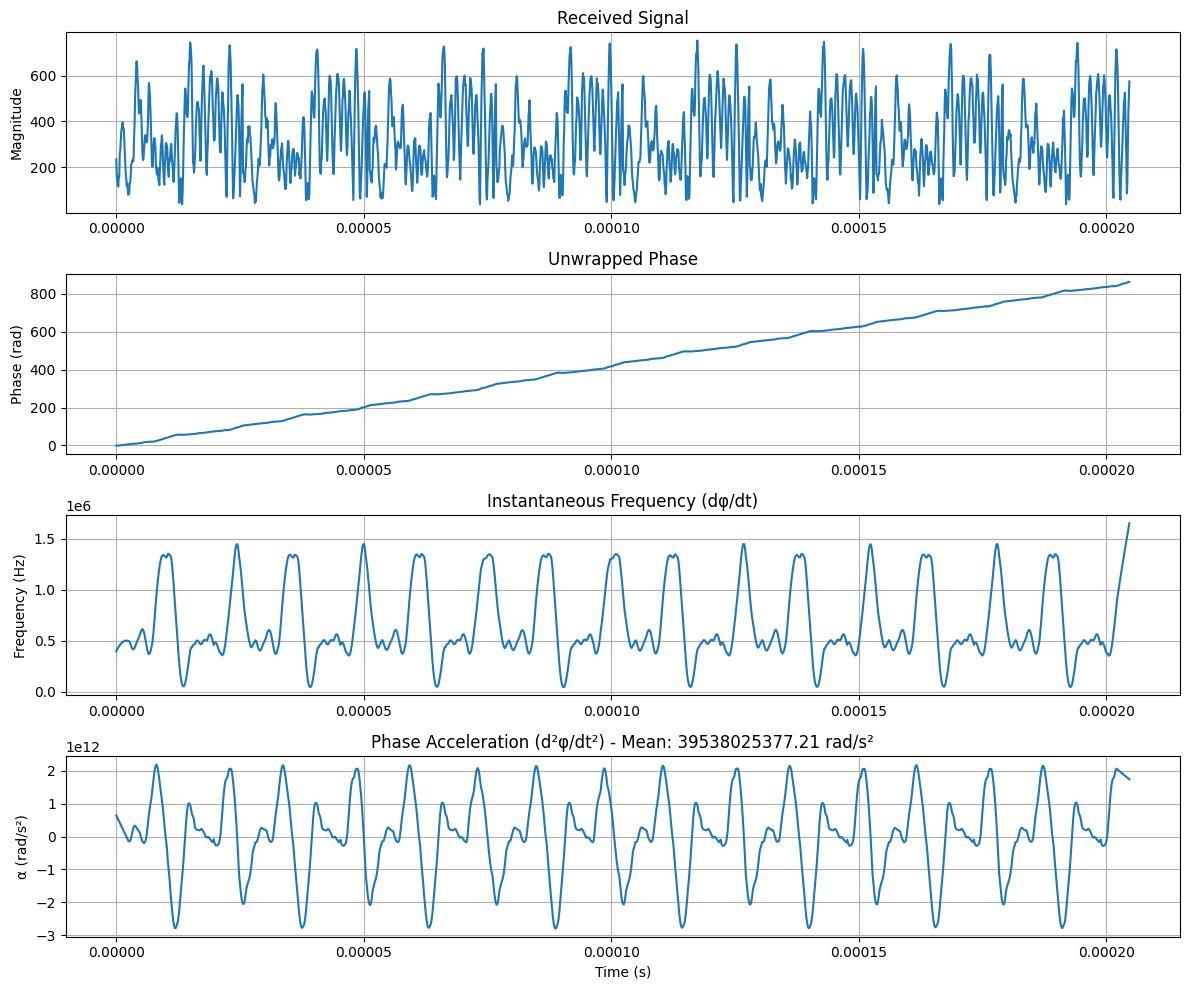

In [330]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import hilbert, savgol_filter
from scipy.fft import fft, fftfreq

class mmWavePhaseAnalyzer:
    """Analyze phase acceleration from mmWave radar data"""
    
    def __init__(self, data, fs, fc, samples_per_chirp=256):
        """
        Initialize analyzer
        
        Parameters:
        - data: 1D array - Complex IQ data or real signal from RX antenna
        - fs: Sampling frequency (Hz)
        - fc: Carrier frequency (Hz)
        - samples_per_chirp: Number of samples per chirp (default: 256)
        """
        self.fs = fs
        self.fc = fc
        self.dt = 1/fs
        self.samples_per_chirp = samples_per_chirp
        
        # Convert to complex if real-valued
        if np.isrealobj(data):
            self.signal = hilbert(data)
        else:
            self.signal = data
            
        self.time = np.arange(len(self.signal)) * self.dt
        self.num_chirps = len(self.signal) // samples_per_chirp
        
    def extract_phase(self, unwrap=True):
        """Extract instantaneous phase from signal"""
        phase = np.angle(self.signal)
        
        if unwrap:
            phase = np.unwrap(phase)
            
        return phase
    
    def calculate_inst_frequency(self, phase=None, smooth=True, window=51, poly=3):
        """
        Calculate instantaneous frequency (first derivative of phase)
        
        Parameters:
        - phase: Unwrapped phase (if None, will be computed)
        - smooth: Apply smoothing filter
        - window: Savitzky-Golay filter window size (must be odd)
        - poly: Polynomial order for smoothing
        """
        if phase is None:
            phase = self.extract_phase(unwrap=True)
        
        # First derivative
        if smooth and len(phase) > window:
            omega = savgol_filter(phase, window, poly, deriv=1, delta=self.dt)
        else:
            omega = np.gradient(phase, self.dt)
        
        # Convert to Hz
        freq = omega / (2 * np.pi)
        
        return omega, freq
    
    def calculate_phase_acceleration(self, phase=None, smooth=True, window=51, poly=3):
        """
        Calculate phase acceleration (second derivative of phase)
        
        Parameters:
        - phase: Unwrapped phase (if None, will be computed)
        - smooth: Apply smoothing filter
        - window: Savitzky-Golay filter window size (must be odd)
        - poly: Polynomial order for smoothing
        """
        if phase is None:
            phase = self.extract_phase(unwrap=True)
        
        # Second derivative
        if smooth and len(phase) > window:
            alpha = savgol_filter(phase, window, poly, deriv=2, delta=self.dt)
        else:
            alpha = np.gradient(np.gradient(phase, self.dt), self.dt)
        
        return alpha
    
    def estimate_target_acceleration(self, alpha):
        """
        Estimate physical acceleration from phase acceleration
        Assumes Doppler scenario: alpha = 2*pi*fc * (a/c)
        
        Returns acceleration in m/s²
        """
        c = 3e8  # Speed of light
        a = (alpha * c) / (2 * np.pi * self.fc)
        return a
    
    def analyze(self, smooth=True, window=51, poly=3):
        """
        Complete analysis pipeline
        
        Returns dictionary with all results
        """
        # Extract phase
        phase = self.extract_phase(unwrap=True)
        
        # Calculate derivatives
        omega, freq = self.calculate_inst_frequency(phase, smooth, window, poly)
        alpha = self.calculate_phase_acceleration(phase, smooth, window, poly)
        
        # Estimate physical parameters
        target_accel = self.estimate_target_acceleration(alpha)
        
        results = {
            'time': self.time,
            'signal': self.signal,
            'phase': phase,
            'angular_freq': omega,
            'frequency': freq,
            'phase_accel': alpha,
            'target_accel': target_accel,
            'mean_phase_accel': np.mean(alpha),
            'std_phase_accel': np.std(alpha),
            'mean_target_accel': np.mean(target_accel),
            'std_target_accel': np.std(target_accel)
        }
        
        return results
    
    def plot_analysis(self, results):
        """Plot comprehensive analysis"""
        fig, axes = plt.subplots(4, 1, figsize=(12, 10))
        
        # Signal magnitude
        axes[0].plot(results['time'], np.abs(results['signal']))
        axes[0].set_ylabel('Magnitude')
        axes[0].set_title('Received Signal')
        axes[0].grid(True)
        
        # Unwrapped phase
        axes[1].plot(results['time'], results['phase'])
        axes[1].set_ylabel('Phase (rad)')
        axes[1].set_title('Unwrapped Phase')
        axes[1].grid(True)
        
        # Instantaneous frequency
        axes[2].plot(results['time'], results['frequency'])
        axes[2].set_ylabel('Frequency (Hz)')
        axes[2].set_title('Instantaneous Frequency (dφ/dt)')
        axes[2].grid(True)
        
        # Phase acceleration
        axes[3].plot(results['time'], results['phase_accel'], label='Phase Accel')
        axes[3].set_ylabel('α (rad/s²)')
        axes[3].set_xlabel('Time (s)')
        axes[3].set_title(f'Phase Acceleration (d²φ/dt²) - Mean: {results["mean_phase_accel"]:.2f} rad/s²')
        axes[3].grid(True)
        
        plt.tight_layout()
        return fig


# Initialize analyzer with YOUR data
analyzer = mmWavePhaseAnalyzer(
    data=dca_out[0][:2048],             # Your 1D array
    fs=sampling_frequency,       # Sampling frequency
    fc=77e9,                       # Carrier frequency  
    samples_per_chirp=256        # Already set to 256
)

# Run analysis
results = analyzer.analyze(
    smooth=True,     # Recommended for noisy data
    window=51,       # Smoothing window (adjust based on noise)
    poly=3          # Polynomial order
)

# Print results
print(f"Number of samples: {len(dca_out[0][:2048])}")
print(f"Number of chirps: {analyzer.num_chirps}")
print(f"Mean phase acceleration: {results['mean_phase_accel']:.2f} rad/s²")
print(f"Estimated target acceleration: {results['mean_target_accel']:.2f} m/s²")

# Visualize
fig = analyzer.plot_analysis(results)
plt.show()

# Access specific results
phase = results['phase']              # Unwrapped phase
freq = results['frequency']           # Instantaneous frequency
phase_accel = results['phase_accel']  # Phase acceleration (rad/s²)
target_accel = results['target_accel'] # Target acceleration (m/s²)


# print(example_code)